# Preliminary Draft

### Project Idea 
I will explore my “like” activity on Instagram alongside my music listening history. By looking at when I like posts and listen to music, I aim to see if there are patterns in my Instagram activity across different days of the week and times of day. This will help determine whether I use Instagram more on days when I listen to more music.

### Hypothesis 
I’m more likely to engage with Instagram posts on days when I don’t listen to music, as when I set aside time to listen to music for productivity, I end up spending less time on my phone.


### Import Statements

In [1]:
import pandas as pd
import glob
import json
from pathlib import Path
import matplotlib.pyplot as plt

### Spotify from Downloads into DataFrame

In [8]:
spotify_folder = Path.home() / "Downloads" / "Spotify Account Data 2"
spotify_files = sorted(spotify_folder.glob("StreamingHistory_music_2*.json"))

# Spotify JSON files into dataframes
spotify_dfs = []
for f in spotify_files:
    df_temp = pd.read_json(f)
    spotify_dfs.append(df_temp)

spotify_raw = pd.concat(spotify_dfs, ignore_index=True)

# timestamps and get date
spotify_raw['endTime'] = pd.to_datetime(spotify_raw['endTime'])
spotify_raw['date'] = spotify_raw['endTime'].dt.date

# listening minutes
spotify_raw['minutes_played'] = spotify_raw['msPlayed'] / 1000 / 60

# Weekday / Weekend
spotify_raw['day_of_week'] = spotify_raw['endTime'].dt.dayofweek
spotify_raw['day_type'] = spotify_raw['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# summary
spotify_daily = spotify_raw.groupby('date', as_index=False).agg(
    total_minutes=('minutes_played', 'sum'),
    total_tracks=('trackName', 'count'),
    unique_artists=('artistName', 'nunique'),
    day_type=('day_type', 'first')
)

spotify_daily.head()

,date,total_minutes,total_tracks,unique_artists,day_type
0,2025-06-20,113.095083,118,52,Weekday
1,2025-06-21,167.621800,142,75,Weekend
2,2025-06-22,59.834717,62,38,Weekend
3,2025-06-23,63.471417,49,14,Weekday
4,2025-06-24,39.418767,44,30,Weekday


### Insatgram from Downloads into DataFrame

In [9]:
# Path to Instagram likes file
insta_folder = Path.home() / "Downloads" / "instagram-gabby" / "your_instagram_activity" / "likes"
path = insta_folder / "liked_posts.json"

# load JSON
with open(path, "r") as j:
    data = json.load(j)

# create rows
rows = []
for like in data["likes_media_likes"]:
    for item in like.get("string_list_data", []):
        rows.append({
            "title": like.get("title"),
            "timestamp": item.get("timestamp")
        })

df_insta = pd.DataFrame(rows)

#  timestamps
df_insta['datetime'] = pd.to_datetime(df_insta['timestamp'], unit='s')
df_insta['date'] = df_insta['datetime'].dt.date

# Weekday / Weekend
df_insta['day_of_week'] = df_insta['datetime'].dt.dayofweek
df_insta['day_type'] = df_insta['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Daily summary
insta_daily = df_insta.groupby('date', as_index=False).agg(
    total_likes=('title', 'count'),
    day_type=('day_type', 'first')
)

insta_daily.head()


,date,total_likes,day_type
0,2025-08-18,11,Weekday
1,2025-08-19,2,Weekday
2,2025-08-20,2,Weekday
3,2025-08-21,5,Weekday
4,2025-08-22,5,Weekday


### Merage Spotify & Instagram Data to Compare

In [10]:
# Dates in spotify and instagram datasets
shared_dates = set(spotify_daily['date']).intersection(set(insta_daily['date']))

spotify_aligned = spotify_daily[spotify_daily['date'].isin(shared_dates)]
instagram_aligned = insta_daily[insta_daily['date'].isin(shared_dates)]

# Merge for day by day comparison
combined = pd.merge(
    spotify_aligned,
    instagram_aligned,
    on=['date', 'day_type'],
    how='inner'
)
# first 15 rows from 8/18/2025-9/5/2025
combined.head(15)


,date,total_minutes,total_tracks,unique_artists,day_type,total_likes
0,2025-08-18,44.311350,34,18,Weekday,11
1,2025-08-19,269.188050,162,69,Weekday,2
2,2025-08-20,70.380233,50,27,Weekday,2
3,2025-08-21,261.266250,131,54,Weekday,5
4,2025-08-22,47.781700,18,5,Weekday,5
5,2025-08-23,127.703833,88,12,Weekend,2
6,2025-08-24,143.847200,54,32,Weekend,8
7,2025-08-25,73.001217,24,1,Weekday,6
8,2025-08-26,255.858600,91,10,Weekday,4
9,2025-08-27,122.413450,172,72,Weekday,7


### Summarize Spotify & Instagram Comparison

In [11]:
combined_summary = combined.groupby('day_type').agg(
    total_spotify_minutes=('total_minutes', 'sum'),
    total_spotify_tracks=('total_tracks', 'sum'),
    total_insta_likes=('total_likes', 'sum'),
    days_count=('date', 'count')
).reset_index()

combined_summary


,day_type,total_spotify_minutes,total_spotify_tracks,total_insta_likes,days_count
0,Weekday,6671.969283,4592,791,63
1,Weekend,1522.913100,1111,268,22


### Visual Chart

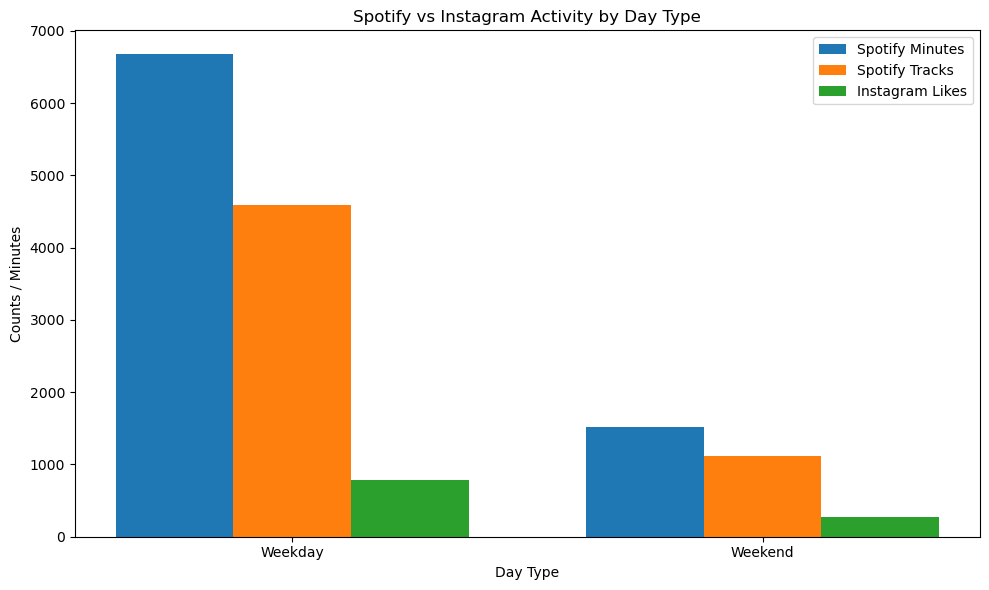

In [16]:
# metrics to plot
metrics = ['total_spotify_minutes', 'total_spotify_tracks', 'total_insta_likes']
labels = combined_summary['day_type']
x = np.arange(len(labels))
width = 0.25
# create bar chart
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, combined_summary['total_spotify_minutes'], width, label='Spotify Minutes')
ax.bar(x, combined_summary['total_spotify_tracks'], width, label='Spotify Tracks')
ax.bar(x + width, combined_summary['total_insta_likes'], width, label='Instagram Likes')
# labels 
ax.set_xlabel('Day Type')
ax.set_ylabel('Counts / Minutes')
ax.set_title('Spotify vs Instagram Activity by Day Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()



### Correlation between Spotify minutes and Instagram likes

In [18]:
corr = combined['total_minutes'].corr(combined['total_likes'])
print(f"Correlation between Spotify minutes and Instagram likes: {corr:.2f}")


Correlation between Spotify minutes and Instagram likes: -0.11


### Scatter Plot

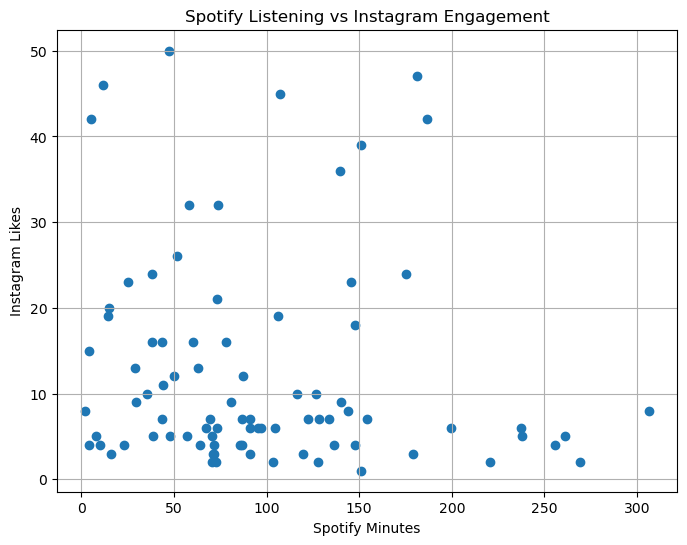

In [24]:
# create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(combined['total_minutes'], combined['total_likes'])
# labels
plt.xlabel('Spotify Minutes')
plt.ylabel('Instagram Likes')
plt.title('Spotify Listening vs Instagram Engagement')
plt.grid(True)

plt.show()


### Final Display summary of Spotify and Instagram by Day Type

In [12]:
print(combined_summary[['day_type', 'total_spotify_minutes', 'total_insta_likes']])


  day_type  total_spotify_minutes  total_insta_likes
0  Weekday            6671.969283                791
1  Weekend            1522.913100                268


# Final Conclusions 

## Data Representation
The data above shows daily activity on Spotify and Instagram. For Spotify, it includes total listening minutes, number of tracks played. For Instagram, it includes the number of posts liked per day. Dates and day types (Weekday vs Weekend) are also included for comparison.

## Tidy Principles
The dataset mostly meets tidy data principles: each row represents a single day (an observation), and each column represents a variable such as total_minutes, total_tracks, total_likes, or day_type.

## Testing Hypothesis
The data can be used to test my hypothesis: I’m more likely to engage with Instagram posts on days when I don’t listen to music, as when I set aside time to listen to music for productivity, I end up spending less time on my phone.

Based on the combined data, the hypothesis is supported. On days with higher Spotify listening (more minutes or tracks), Instagram engagement (likes) tends to be lower, while on days with lower or no Spotify activity, Instagram likes are higher. This shows that dedicating time to music reduces  my time on Instagram.